In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Activation
from keras.models import load_model

In [12]:
df = pd.read_csv('../res/crwal_investor_stock_type.csv') #, index_col='DATEON'
df['DATEON'] = df['DATEON'].str[2:]
df = df.set_index('DATEON')

df2 = pd.read_csv('../res/crawl_investor_daily_volume.csv')
df3 = pd.merge(left=df, right=df2, how='inner', left_on='DATEON', right_on='DATEON')

df3['FOR_BUY_D14']=df3.FOR_BUY.rolling(14).sum().shift(1)
df3['FOR_BUY_D7']=df3.FOR_BUY.rolling(7).sum().shift(1)
df3['COMP_BUY_D14']=df3.COMP_BUY.rolling(14).sum().shift(1)
df3['COMP_BUY_D7']=df3.COMP_BUY.rolling(7).sum().shift(1)

#df3['PRED_OUT']=df3.END_VALUE.shift(-1)
#df3 = df3.dropna
df3 = df3.dropna()

# def convert_dateformat(x: str) -> str:
#     return x.replace('.', '')

from typing import Callable   
df3['DATEON'] = df3['DATEON'].apply(lambda x: x.replace('.', ''))
df3

,DATEON,TYPE_CODE_x,END_VALUE,DELTA,UPDOWN_PER,VOLUME,COMP_BUY,FOR_BUY,FOR_CONT,FOR_PER,...,INSURANCE,TOOSIN,BANK,ETC_FIN,GOV_FUND,ETC_FUND,FOR_BUY_D14,FOR_BUY_D7,COMP_BUY_D14,COMP_BUY_D7
14,160202,233740,11985.0,40.0,0.33,1091070.0,66242.0,0.0,0.0,0.00,...,-76.0,-156.0,-50.0,-50.0,-96.0,586.0,0.0,0.0,763967.0,677038.0
15,160203,233740,11870.0,-115.0,-0.96,1198020.0,-46529.0,0.0,0.0,0.00,...,45.0,2.0,2.0,57.0,17.0,681.0,0.0,0.0,871546.0,718417.0
16,160204,233740,11875.0,5.0,0.04,1816400.0,-50894.0,0.0,0.0,0.00,...,298.0,161.0,-15.0,1.0,152.0,416.0,0.0,0.0,769026.0,351588.0
17,160205,233740,11795.0,-80.0,-0.67,1017640.0,-8125.0,0.0,0.0,0.00,...,265.0,98.0,-106.0,-23.0,608.0,-4118.0,0.0,0.0,928365.0,201153.0
18,160211,233740,10645.0,-1150.0,-9.75,1942020.0,-678720.0,0.0,0.0,0.00,...,13.0,-59.0,-37.0,-12.0,201.0,616.0,0.0,0.0,831238.0,360149.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2095,240722,233740,10210.0,-530.0,-4.93,25376100.0,-10601000.0,-671720.0,50339.0,0.05,...,-73.0,-703.0,-38.0,-7.0,-936.0,-332.0,291888.0,54884.0,-4560341.0,-16967239.0
2096,240723,233740,10275.0,65.0,0.64,20878400.0,-990217.0,192766.0,343105.0,0.32,...,86.0,769.0,-137.0,-35.0,137.0,-266.0,151081.0,-669333.0,-5561821.0,-26385949.0
2097,240724,233740,10360.0,85.0,0.83,18236500.0,1033550.0,160263.0,603368.0,0.55,...,165.0,382.0,-51.0,-21.0,-127.0,-101.0,-643820.0,-783543.0,-13337018.0,-27170255.0
2098,240725,233740,9935.0,-425.0,-4.10,27670600.0,-8731450.0,-560720.0,42648.0,0.04,...,-7.0,-1247.0,-139.0,82.0,-216.0,48.0,-284588.0,-255478.0,-15418978.0,-26906708.0


In [13]:
# We want 80% of the data to be used for training, and 20% for testing
n_train_rows = int(df3.shape[0]*.8)-1

# Split into train and test sets but keep all 9 columns
train = df3.iloc[:n_train_rows, :]
test = df3.iloc[n_train_rows:, :]

# The total rows of the two datasets should equal the total amount of rows in your CSV
print(train.shape)
print(test.shape)

(1667, 25)
(419, 25)


In [14]:
# Normalise features
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(train.values)
test_set_scaled = sc.fit_transform(test.values)

In [15]:
steps = 50

# Prepare the training data
x_train = []
y_train = []

for i in range(steps, training_set_scaled.shape[0]-steps):
    x_train.append(training_set_scaled[i-steps:i, :])
    y_train.append(training_set_scaled[i, :])

x_train, y_train = np.array(x_train), np.array(y_train)
print(x_train.shape)

(1567, 50, 25)


In [16]:
# Prepare the test data
x_test = []
y_test = []

for i in range(steps, test_set_scaled.shape[0]):
    x_test.append(test_set_scaled[i-steps:i, :])
    y_test.append(test_set_scaled[i, :])

x_test, y_test = np.array(x_test), np.array(y_test)
print(x_test.shape)

(369, 50, 25)


In [17]:
model = Sequential()

epochs = 10

model.add(LSTM(units=50, return_sequences = True, input_shape = (x_train.shape[1],25)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=25))
model.compile(loss="mse", optimizer="adam")
model.fit(x_train, y_train, batch_size = 32, epochs = epochs)
model.summary

model.save("multiple_features_"+str(steps)+"_steps_"+str(epochs)+"_epochs.h5")
print("Saved model to disk")

2024-08-01 11:10:24.453988: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-08-01 11:10:24.454416: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-01 11:10:24.454952: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/10


2024-08-01 11:10:25.291830: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-08-01 11:10:25.292653: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-01 11:10:25.293075: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

49/49 [==============================] - 4s 40ms/step - loss: 0.0700
Epoch 2/10
49/49 [==============================] - 2s 41ms/step - loss: 0.0247
Epoch 3/10
49/49 [==============================] - 2s 41ms/step - loss: 0.0182
Epoch 4/10
49/49 [==============================] - 2s 41ms/step - loss: 0.0152
Epoch 5/10
49/49 [==============================] - 2s 41ms/step - loss: 0.0131
Epoch 6/10
49/49 [==============================] - 2s 41ms/step - loss: 0.0117
Epoch 7/10
49/49 [==============================] - 2s 42ms/step - loss: 0.0108
Epoch 8/10
49/49 [==============================] - 2s 40ms/step - loss: 0.0099
Epoch 9/10
49/49 [==============================] - 2s 41ms/step - loss: 0.0095
Epoch 10/10
49/49 [==============================] - 2s 40ms/step - loss: 0.0089
Saved model to disk


In [18]:
# Evaluate the model on the test data using `evaluate`
print('\n# Evaluate on test data')
results = model.evaluate(x_test, y_test, batch_size=32)
print('test loss, test acc:', results)


# Evaluate on test data


2024-08-01 11:10:50.036719: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-08-01 11:10:50.037604: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-01 11:10:50.038035: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

12/12 [==============================] - 1s 9ms/step - loss: 0.0491
test loss, test acc: 0.04907386377453804


In [19]:
# Predict values from test data trained using training data
y_hat = model.predict(x_test)
y_hat = sc.inverse_transform(y_hat)

2024-08-01 11:14:45.554027: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-08-01 11:14:45.555412: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-01 11:14:45.558512: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

12/12 [==============================] - 1s 13ms/step


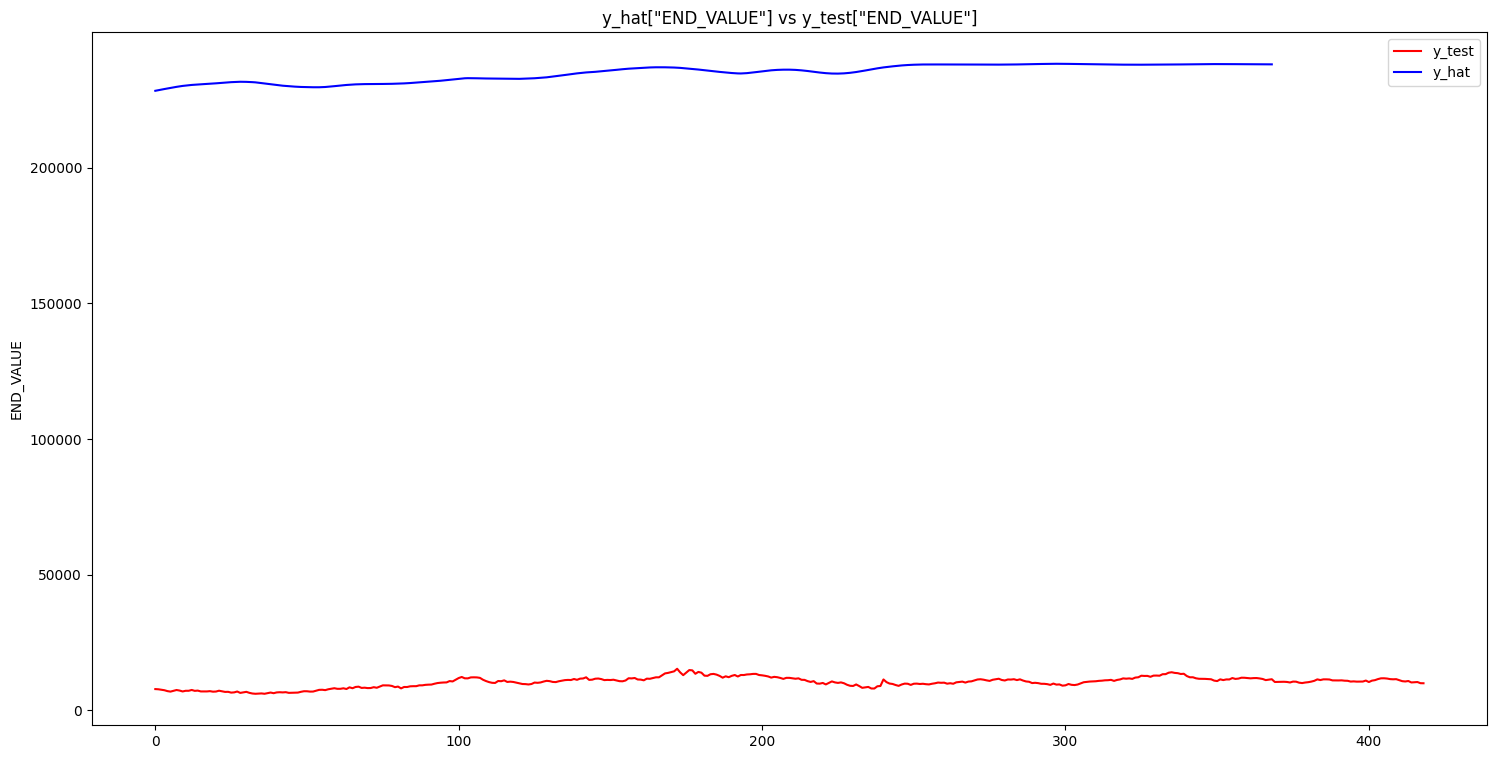

In [22]:
y_test = test.reset_index()

# Visualise the ask_price predictions
plt.figure(figsize = (18,9))
plt.plot(y_test['END_VALUE'], color = 'red', label = 'y_test')
plt.plot(y_hat[:,0], color = 'blue', label = 'y_hat')
plt.title('y_hat["END_VALUE"] vs y_test["END_VALUE"]')
plt.ylabel('END_VALUE')
plt.legend()
plt.show()

# Visualise the bid_price predictions
# plt.figure(figsize = (18,9))
# plt.plot(y_test['bid_price'], color = 'red', label = 'y_test')
# plt.plot(y_hat[:,3], color = 'blue', label = 'y_hat')
# plt.title('y_hat["bid_price"] vs y_test["bid_price"]')
# plt.ylabel('bid_price')
# plt.legend()
# plt.show()